# Gaussian Mixture Models and the EM Algorithm

This notebook explores Gaussian mixture models, their esitmation, resulting classification, and the EM algorithm when labels are not provided.

In [1]:
import numpy as np  # for numerical python libraries

import scipy.stats as st  # for statistical libraries

import matplotlib.pyplot as plt  # for plotting

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Generate some random Gaussian mixture model data
In the mixture model, a generative model, the probability that a point in feature space is generated is Gaussian with a class specific mean and covariance matrix

In [2]:
# some model parameters
pi=np.array([0.5,0.25,0.25])
mu=np.array([[1,1],[1.8,1.8],[1.5,0.5]])
Sigma=np.array([[[0.05,0.025],[0.025,0.05]],[[0.16,-0.1],[-0.1,0.4]],[[0.04,-0.01],[-0.01,0.2]]])


In [3]:
def GenerateData(pi,mu,Sigma,N):
    # this function simply generates multivariate normal data 
    # pi represents the probability of each class (in this case, we have 3)
    # mu, sigma are the vector of means and and covariance matrices. each mean is in R^2
    # each covariance matrix is in R^{2x2}
    
    d = mu.shape[1] # data dimension
    K = pi.size # number of classes
    
    X = np.zeros((N,d)) # store features
    Y = np.zeros(N) # store labels
    Y = Y.astype(int)
    
    # used generate random labels
    cpi = np.cumsum(pi)
    U = np.random.uniform(0,1,N)
        
    for i in range(0,N):
    
        # generate a label for point i
        Y[i] = int(sum(U[i] > cpi))
    
        # generate random point in feature space conditional on being in class Y[i]
        X[i,:] = np.random.multivariate_normal(mu[Y[i],:], Sigma[Y[i],:,:])
    
    return X,Y
    

the conditional density
$$
f_{X|Y=k}(x; \mu_k, \Sigma_k) = \frac{1}{\sqrt{(2\pi)^d\det(\Sigma_k)}} \exp\{-\tfrac{1}{2}(x-\mu_k)^\intercal(\Sigma_k)^{-1}(x-\mu_k)\}
$$

In [4]:
# the conditional density f_{X|Y=y}(x)
def fxy(mu,Sigma,bins):
    
    K = mu.shape[0] #3 in this case 
    
    f = np.zeros((K,bins.shape[1],bins.shape[1]))
    
    for k in range(0,K):
        for i in range(0,bins.shape[1]):
            for j in range(0,bins.shape[1]):
                f[k,i,j] =  st.multivariate_normal.pdf([bins[0,i],bins[1,j]],mu[k,:],Sigma[k,:,:])
                
    return f

                
bins=np.zeros((2,100))
bins[0,:] = np.linspace(0,4,100)
bins[1,:] = np.linspace(-1,4,100)

f = fxy(mu,Sigma,bins)


## Plot a random sample

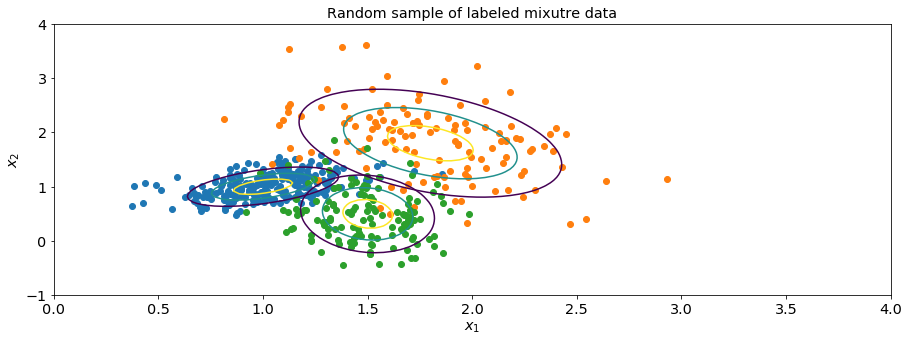

In [5]:
x,y =  GenerateData(pi,mu,Sigma,500) #generate the mvn data

for i in range(0,mu.shape[0]):
    plt.contour(bins[0,:],bins[1,:],f[i,:,:].T, 3) # plotting the countours - differing levels of probability


for i in range(0,mu.shape[0]):
    plt.scatter(x[y==i,0],x[y==i,1]) # plotting the points
    

plt.xlabel(r'$x_1$')    
plt.ylabel(r'$x_2$')
plt.title('Random sample of labeled mixutre data')

plt.show()

## Estimate the model from the data using labels

In [6]:
def EstimateMixtureModel(x,y): #No EM here - this is straight up classification
    
    Y = np.unique(y) # get the unique list of labels
    K = Y.size # number of unique labels
    
    pi = np.zeros(K) #zeros of length K
    mu = np.zeros((K,x.shape[1])) # matrices of 0's
    Sigma = np.zeros((K,x.shape[1],x.shape[1]))
    
    # estimate the parameters for every unique point with the MLE estimates 
    for k in range(K):
        idx = (y==Y[k])
        pi[k] = np.sum(idx)/y.size
        mu[k,:] = np.mean(x[idx,:],axis=0)
        Sigma[k,:,:] = np.cov(x[idx,:].T)
        
    return pi, mu, Sigma

In [7]:
pih,muh,Sigmah = EstimateMixtureModel(x,y)

# Bayes classifier
This provides the (posterior) probability that a point in feature space comes from a given class $\gamma_{k}(x)=\mathbb P(X=x|Y=k)$ and equals using Bayes rule

$$
\gamma_{k}(x) = \frac{\pi_k \; f_{X|Y=k}(x; \mu_k, \Sigma_k)}{\sum_{k\in{\mathcal K}} \pi_k \;f_{X|Y=k}(x; \mu_k, \Sigma_k)}
$$

In [8]:
# compute the posterior probability of a point in feature space being from a given class
def Posterior(pi,mu,Sigma,bins):
    K = pi.size
    
    p = np.zeros((K,bins.shape[1],bins.shape[1]))
    
    for i in range(0,bins.shape[1]):
        for j in range(0,bins.shape[1]):
                 
            denom = 0
            # for every quantile, calculate the probability of it being in a certain class
            # divide by the sum of probabilities for that point, across that class
            # what results is the probability of the point (i,j) being in class k
            for k in range(0,K):
                 p[k,i,j] = st.multivariate_normal.pdf([bins[0,i],bins[1,j]],mu[k,:],Sigma[k,:,:])*pi[k]
                 denom += p[k,i,j]

            for k in range(0,K):
                 p[k,i,j] /= denom
                 
    return p

In [9]:
# use the true and estimated model parameters to compute the posterior
p = Posterior(pi,mu,Sigma,bins)
ph = Posterior(pih,muh,Sigmah,bins)

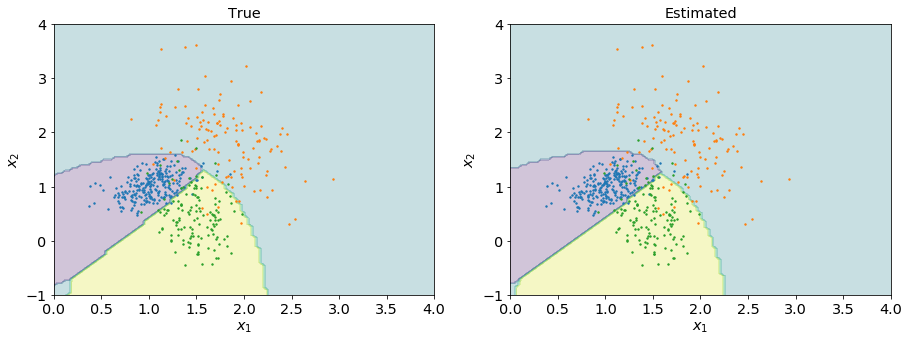

In [10]:
# plot the results
plt.subplot(1,2,1)
plt.contourf(bins[0,:],bins[1,:],np.argmax(p,axis=0).T,alpha=0.25)

for i in range(0,mu.shape[0]):
    plt.scatter(x[y==i,0],x[y==i,1],s=2)
    
plt.xlabel(r'$x_1$')    
plt.ylabel(r'$x_2$')
plt.title('True')

plt.subplot(1,2,2)
plt.contourf(bins[0,:],bins[1,:],np.argmax(ph,axis=0).T, alpha=0.25)

for i in range(0,mu.shape[0]):
    plt.scatter(x[y==i,0],x[y==i,1],s=2)
    
plt.xlabel(r'$x_1$')    
plt.ylabel(r'$x_2$')
plt.title('Estimated')
plt.show()

# the estimated comes very close to the true. We are able to identify the regions quite well

# Estimating without the labels... EM Algorithm
Responsibilities at iteration m for data point n in class k is
$$
\gamma_{n,k}^m = \frac{\pi_k^m \; f_{X_n|Y_n=k}(x_n; \mu_k^m, \Sigma_k^m)}{\sum_{k\in{\mathcal K}} \pi_k^m \;f_{X_n|Y_n=k}(x_n; \mu_k^m, \Sigma_k^m)}
$$
where the probability that data point n occurs given that it is in class k is
$$
f_{X_n|Y_n=k}(x_n; \mu_k^m, \Sigma_k^m) = \frac{1}{\sqrt{(2\pi)^d\det(\Sigma_k^m)}} \exp\{-\tfrac{1}{2}(x_n-\mu_k^m)^\intercal(\Sigma_k^m)^{-1}(x_n-\mu_k^m)\}
$$

In [11]:
# now we actually use EM - we no longer have the labels
# this function represents the e-step
def Reponsibilities(x,pi,mu,Sigma):
    
    K = pi.size
    
    g = np.zeros((K, x.shape[0]))
    
    for n in range(0,x.shape[0]):
        
        denom = 0
                
        for k in range(0,K):
            g[k,n] = st.multivariate_normal.pdf(x[n,:], mu[k,:].T, Sigma[k,:,:])*pi[k]
            #posterior probability that point n is in state k
            # similar to what was in the "Bayes" function, except here we are given 
            # a data point as opposed to calculating the probability for an arbitrary point
            # in feature space
            denom += g[k,n]
            
        for k in range(0,K):
            g[k,n] /= denom
            
    return g

The m-step update rules are for class $l$
$$
\pi_l^{m+1} = \frac{\sum_{n\in\mathcal{N}} \gamma_{n,l}^m}{\sum_{n\in\mathcal{N},k\in\mathcal{K}} \gamma_{n,l}^m}
$$

$$
\mu_l^{m+1} = \frac{\sum_{n\in\mathcal{N}} x_n \gamma_{n,l}^m}{\sum_{n\in\mathcal{N}} \gamma_{n,l}^m}
$$

$$
\Sigma_{l,ij}^{m+1} = \frac{\sum_{n\in\mathcal{N}} (x_{n,i}-\mu_{l,i}^{m+1})(x_{n,j}-\mu_{l,j}^{m+1}) \gamma_{n,l}^m}{\sum_{n\in\mathcal{N}} \gamma_{n,l}^m}
$$



In [12]:
def EM(x, pi, mu, Sigma, iter):
    
    K = pi.size
    d = x.shape[1]
        
    for m in range(iter):
        
        # e-step
        gamma = Reponsibilities(x,pi,mu,Sigma)
        
        #m-step
        #
        
        #  compute update to pi
        numer = np.sum(gamma, axis=1) # sum_n  gamma_{n,k} gives array shape (1,K)
        denom = np.sum(numer) # sum_{n,k}  gamma_{n,k}
        pi = numer / denom
        
        #  compute update to mu
        numer = np.matmul(gamma, x)   # sum_n x_{n,l} gamma_{n,k} gives array shape (K,d) 
        sum_gamma = np.sum(gamma, axis=1) # sum_n  gamma_{n,k} gives array shape (1,K)
        for k in range(0,K):
            mu[k,:] = numer[k,:]/sum_gamma[k]
                        
        #  compute update to Sigma
        for k in range(0,K):
            for i in range(0,d):
                for j in range(0,d):
                    Sigma[k,i,j] = np.sum( (x[:,i]-mu[k,i])*(x[:,j]-mu[k,j])*gamma[k,:] )/sum_gamma[k]

    print('   -- estimated parameters -----')
    print(pi, '\n\n', mu, '\n\n', Sigma, '\n\n')
            
    return pi, mu, Sigma

In [13]:
def InitialGuess(x,K):
    # generate an initial guess depending on the number of classes that are specified

    pi_h = np.ones(K)/K
    mu_h = np.mean(x,axis=0)
    Sigma_h = np.cov(x.T)

    pi0 = pi_h * np.random.uniform(0.99,1.01,K)
    pi0 = pi0 / sum(pi0)

    mu0 = np.tile(mu_h,(K,1)) * np.random.uniform(0.99,1.01,(K,2))

    Sigma0 = np.tile(Sigma_h,(K,1,1))
    
    return pi0, mu0, Sigma0

In [14]:
# generate an initial guess using a list of classes

Kfitmax = 4 # largest number of possible classes
pe = np.empty((Kfitmax,Kfitmax,bins.shape[1],bins.shape[1]))
pie = np.empty((Kfitmax,Kfitmax))
mue = np.empty((Kfitmax,Kfitmax,2))
Sigmae = np.empty((Kfitmax,Kfitmax,2,2))

# fitting the parameters using 2, 3, and 4 classes
for Kfit in range (2,Kfitmax+1):
    
    print('-------- Kfit = ', Kfit, '-------- ')
    
    pi0,mu0,Sigma0 = InitialGuess(x,Kfit)

    print('   -- initial guess -- ')
    print(pi0, '\n\n', mu0, '\n\n', Sigma0, '\n\n')

    # use EM to update the estimate
    pie[Kfit-1,0:Kfit], mue[Kfit-1,0:Kfit,:], Sigmae[Kfit-1,0:Kfit,:,:]= EM(x, pi0, mu0, Sigma0, 100)

    pe[Kfit-1,0:Kfit,:,:] = Posterior(pie[Kfit-1,0:Kfit],mue[Kfit-1,0:Kfit,:],Sigmae[Kfit-1,0:Kfit,:,:],bins)

-------- Kfit =  2 -------- 
   -- initial guess -- 
[ 0.50174669  0.49825331] 

 [[ 1.35053388  1.07633778]
 [ 1.33587595  1.06618159]] 

 [[[ 0.17927398  0.05468603]
  [ 0.05468603  0.4289084 ]]

 [[ 0.17927398  0.05468603]
  [ 0.05468603  0.4289084 ]]] 


   -- estimated parameters -----
[ 0.55240631  0.44759369] 

 [[ 1.60819392  1.1368491 ]
 [ 1.00736562  1.00252676]] 

 [[[ 0.12577181  0.04848288]
  [ 0.04848288  0.72511996]]

 [[ 0.04508793  0.01751565]
  [ 0.01751565  0.05144996]]] 


-------- Kfit =  3 -------- 
   -- initial guess -- 
[ 0.33429526  0.33473193  0.33097281] 

 [[ 1.33155817  1.08577518]
 [ 1.32636978  1.07836863]
 [ 1.33278288  1.08445339]] 

 [[[ 0.17927398  0.05468603]
  [ 0.05468603  0.4289084 ]]

 [[ 0.17927398  0.05468603]
  [ 0.05468603  0.4289084 ]]

 [[ 0.17927398  0.05468603]
  [ 0.05468603  0.4289084 ]]] 


   -- estimated parameters -----
[ 0.2448356   0.50041001  0.2547544 ] 

 [[ 1.50066374  0.40282618]
 [ 1.02750861  1.02249689]
 [ 1.79653611  1.8

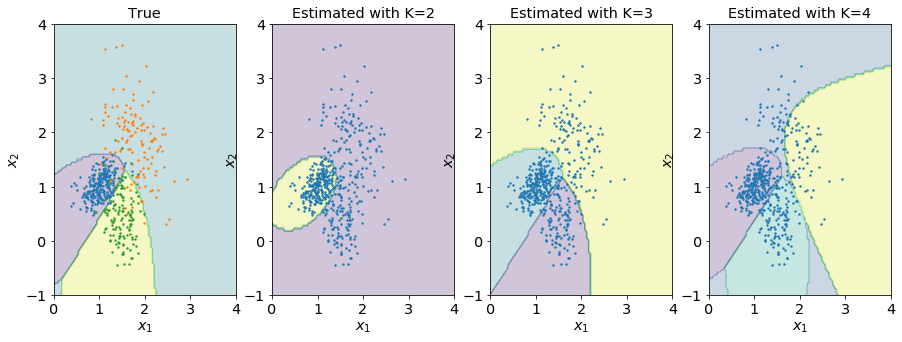

In [15]:
# plot the results
plt.subplot(1,Kfitmax,1)
plt.contourf(bins[0,:],bins[1,:],np.argmax(p,axis=0).T,alpha=0.25)

for i in range(0,mu.shape[0]):
    plt.scatter(x[y==i,0],x[y==i,1],s=2)
    
plt.xlabel(r'$x_1$')    
plt.ylabel(r'$x_2$')
plt.title('True')

for Kfit in range(2,Kfitmax+1):
    plt.subplot(1,Kfitmax,Kfit)
    plt.contourf(bins[0,:],bins[1,:],np.argmax(pe[Kfit-1,:,:,:],axis=0).T, alpha=0.25)
    plt.scatter(x[:,0],x[:,1],s=2)

    plt.xlabel(r'$x_1$')    
    plt.ylabel(r'$x_2$')
    plt.title(r'Estimated with K=' + str(Kfit))
    
plt.show()